In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import logging
import os
from util import getDefaultHyperparams
import time
from DayDataloaders import create_Dataloaders
# Import the metrics file
from SequenceLoss import SequenceLoss
from network import Net



Text(0.5, 1.0, 'Train vs val accuracy')

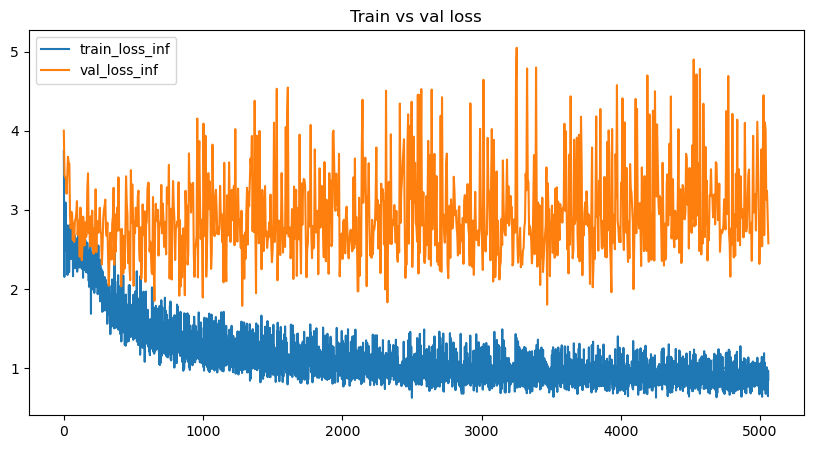

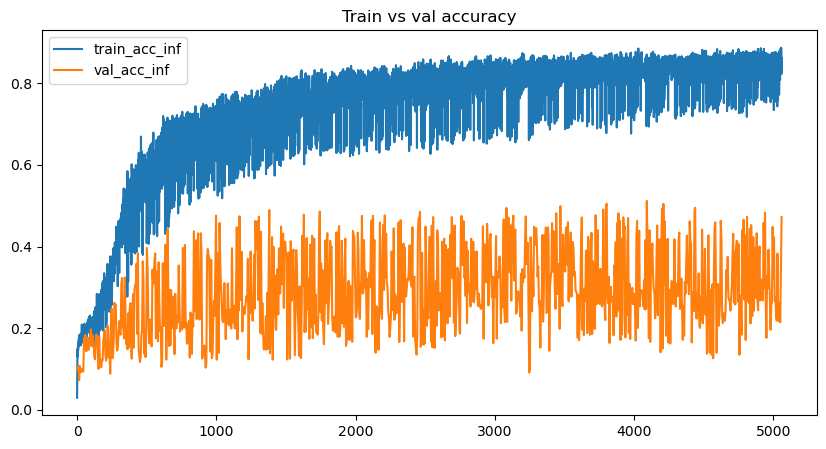

In [10]:
metrics_inf = torch.load('Model/metrics_inf_107776.pth')

len_train_loss = len(metrics_inf['train_loss'])
len_valloss = len(metrics_inf['val_loss'])
valloss_range = np.linspace(0, len_train_loss, len_valloss)
# train loss
plt.figure(figsize=(10, 5))
plt.plot(metrics_inf['train_loss'], label='train_loss_inf')
plt.plot(valloss_range, metrics_inf['val_loss'], label='val_loss_inf')
plt.legend()
plt.title('Train vs val loss')

len_train_acc = len(metrics_inf['train_acc'])
len_valacc = len(metrics_inf['val_acc'])
valacc_range = np.linspace(0, len_train_acc, len_valacc)
# train acc
plt.figure(figsize=(10, 5))
plt.plot(metrics_inf['train_acc'], label='train_acc_inf')
plt.plot(valacc_range, metrics_inf['val_acc'], label='val_acc_inf')
plt.legend()
plt.title('Train vs val accuracy')


Text(0.5, 1.0, 'Train vs val accuracy')

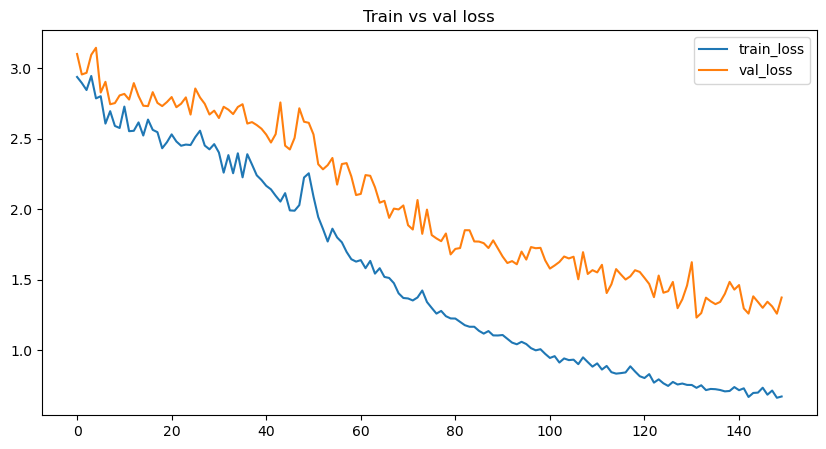

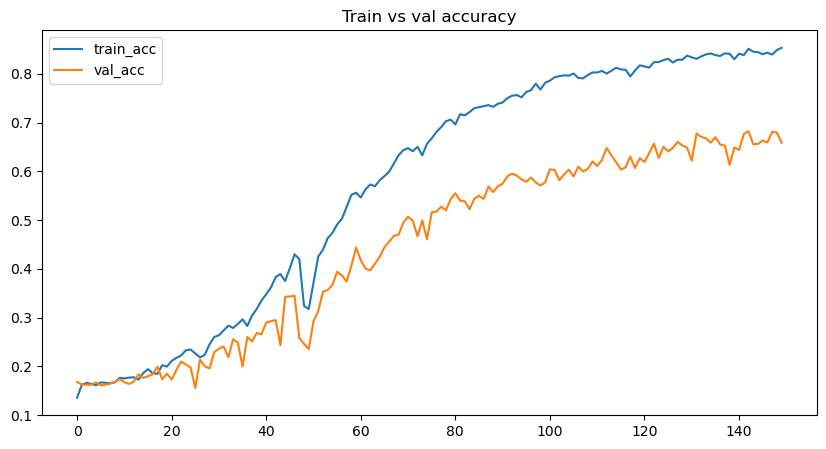

In [20]:
metrics = torch.load('trainOutputs/metrics_468079.pth')

trainloss = np.concatenate(metrics['trainloss_per_batch'])
valloss = np.concatenate(metrics['valloss_per_batch'])
trainacc = np.concatenate(metrics['trainacc_per_batch'])
valacc = np.concatenate(metrics['valacc_per_batch'])

plt.figure(figsize=(10, 5))
plt.plot(metrics['trainloss_per_epoch'], label='train_loss')
plt.plot(metrics['valloss_per_epoch'], label='val_loss')
plt.legend()
plt.title('Train vs val loss')

plt.figure(figsize=(10, 5))
plt.plot(metrics['trainacc_per_epoch'], label='train_acc')
plt.plot(metrics['valacc_per_epoch'], label='val_acc')
plt.legend()
plt.title('Train vs val accuracy')


Text(0.5, 1.0, 'Val acc comparison')

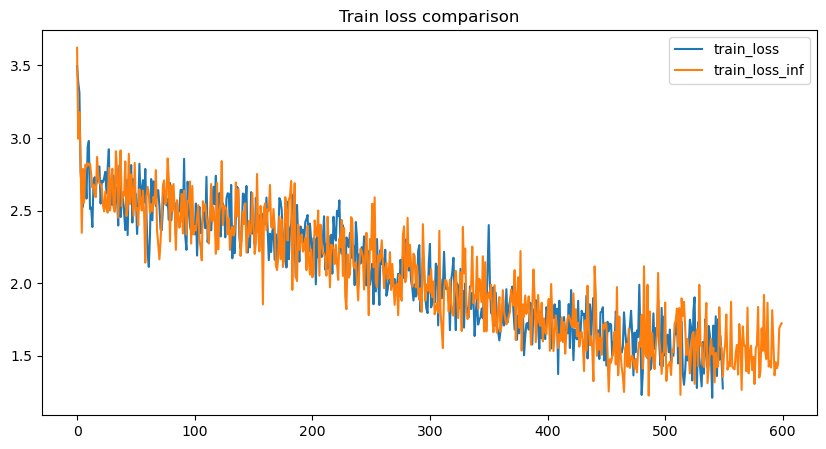

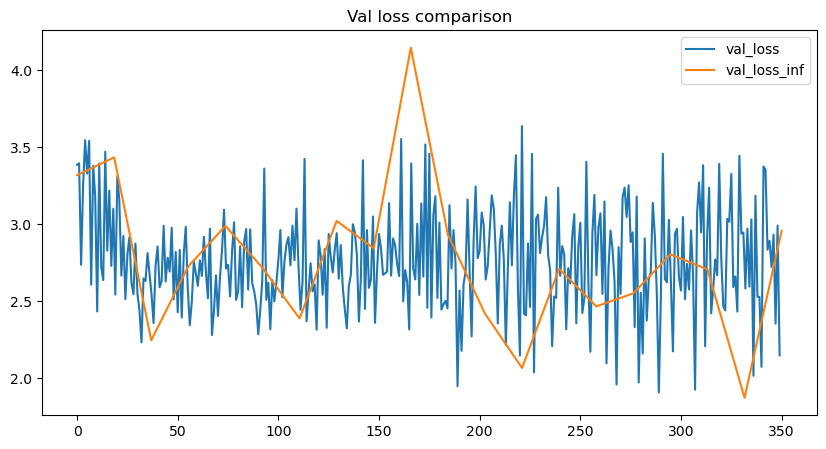

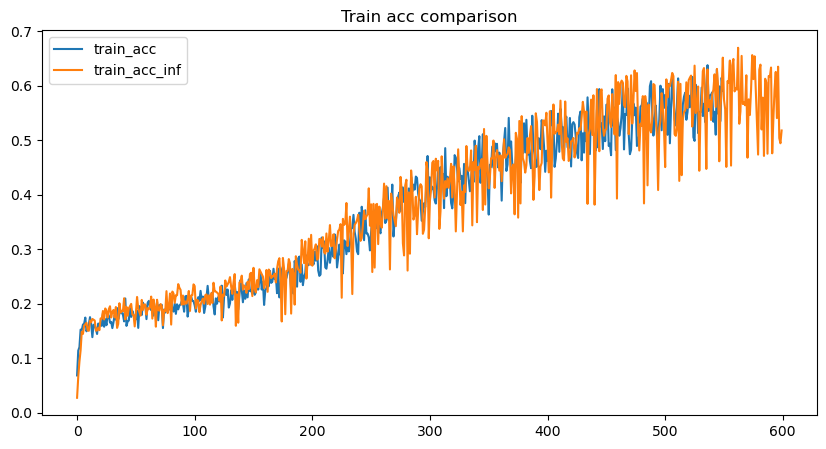

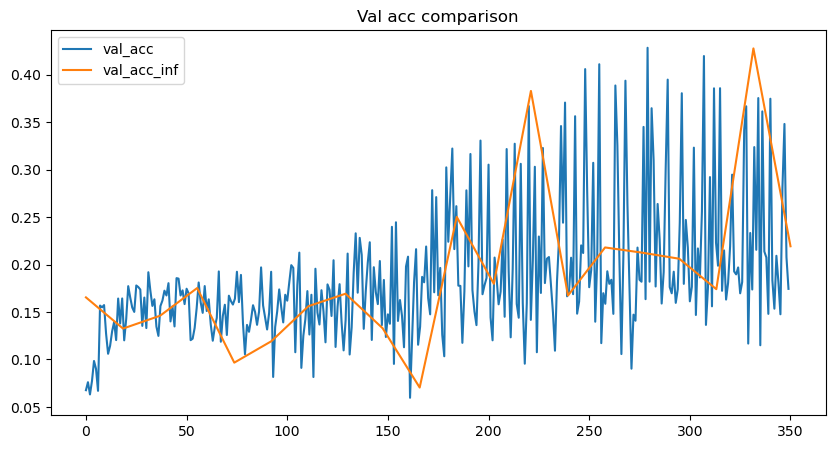

In [17]:

infinite = 0

metrics = torch.load('Model/metrics_124813.pth')
metrics_inf = torch.load('Model/metrics_inf_1.pth')

trainloss = np.concatenate(metrics['trainloss_per_batch'])
valloss = np.concatenate(metrics['valloss_per_batch'])
trainacc = np.concatenate(metrics['trainacc_per_batch'])
valacc = np.concatenate(metrics['valacc_per_batch'])

# train loss comparison
plt.figure(figsize=(10, 5))
plt.plot(trainloss, label='train_loss')
plt.plot(metrics_inf['train_loss'], label='train_loss_inf')
plt.legend()
plt.title('Train loss comparison')

# val loss comparison
len_valloss = len(valloss)
len_valloss_inf = len(metrics_inf['val_loss'])
vallos_inf_range = np.linspace(0, len_valloss, len_valloss_inf)

plt.figure(figsize=(10, 5))
plt.plot(valloss, label='val_loss')
plt.plot(vallos_inf_range, metrics_inf['val_loss'], label='val_loss_inf')
plt.legend()
plt.title('Val loss comparison')

# train acc comparison
plt.figure(figsize=(10, 5))
plt.plot(trainacc, label='train_acc')
plt.plot(metrics_inf['train_acc'], label='train_acc_inf')
plt.legend()
plt.title('Train acc comparison')

# val acc comparison
len_valacc = len(valacc)
len_valacc_inf = len(metrics_inf['val_acc'])
valacc_inf_range = np.linspace(0, len_valacc, len_valacc_inf)

plt.figure(figsize=(10, 5))
plt.plot(valacc, label='val_acc')
plt.plot(valacc_inf_range, metrics_inf['val_acc'], label='val_acc_inf')
plt.legend()
plt.title('Val acc comparison')





In [18]:
hyperparams = getDefaultHyperparams()

if hyperparams['system'] == 'Linux':
    prepared_data_dir = '/scratch/sem24f8/dataset/'
else:
    prepared_data_dir = 'dataset/'

hyperparams['prepared_data_dir'] = prepared_data_dir

hyperparams['n_channels'] = 192
hyperparams['n_outputs'] = 32
hyperparams['batchSize'] = 2

# Load the prepared data
print('Loading prepared data from dir')
prepared_data = torch.load(prepared_data_dir + 'prepared_data.pth')
print('Data loaded')

manual_prep = False
# loading the testing dataset and creating a DataLoader for each day
Test_finite_loader = create_Dataloaders(manual_prep, hyperparams, days=np.arange(10), mode='testing')
test_loaders = Test_finite_loader.getDataloaders()
viable_test_days = Test_finite_loader.getViableDays()
print('Testing dataloaders ready')



Please set: /n hyperparams['outputDir']
Loading prepared data from dir


KeyboardInterrupt: 

In [ ]:
# Load the model
id = '107776'

from util import testModel

device = torch.device('cpu')
if torch.cuda.is_available():
    print('GPU available')
    device = torch.device(hyperparams['device'])
print(f'Device: {device}')

model = Net(hyperparams).to(device)
state_dict = torch.load(f'Model/model_inf_{id}.pth', map_location=device)
model.load_state_dict(state_dict)


# test the model
criterion = SequenceLoss(hyperparams)
testModel(model, test_loaders, viable_test_days, criterion, hyperparams, device)

GPU available
Device: cuda:0
Testing on day t5.2019.11.25


TypeError: only integer scalar arrays can be converted to a scalar index